In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model, Parameters
from scipy.optimize import curve_fit


In [2]:
#Pull in data for replicate 1
channel_1 = './yfv_3.txt'
channel_1 = np.array(pd.read_csv(channel_1,delimiter="\t")).T #tab-delimited file

#Only need every other cycle; regeneration performed in-between each injection
channel_1 = np.concatenate(np.split(channel_1,17)[1::2]) 

#First 1200 seconds are baselining
channel_1 = channel_1[:,1200:]

#Align time/response at 0
channel_1[1::2] = channel_1[1::2] - channel_1[1::2,0].reshape(-1,1)
channel_1[::2] = channel_1[::2] - channel_1[::2,0].reshape(-1,1)

channel_1 = channel_1[4:] #Lowest 2 concentrations had drift issue; removed
channel_1 = np.vstack([x[~np.isnan(x)][:21500] for x in channel_1]) #process every response curve to be the same total length

In [3]:
#Pull in data for replicate 2
channel_2 = './yfv_4.txt'
channel_2 = np.array(pd.read_csv(channel_2,delimiter="\t")).T #tab-delimited file

#Only need every other cycle; regeneration performed in-between each injection
channel_2 = np.concatenate(np.split(channel_2,17)[1::2])

#First 1200 seconds are baselining
channel_2 = channel_2[:,1200:]

#Align time/response at 0
channel_2[1::2] = channel_2[1::2] - channel_2[1::2,0].reshape(-1,1)
channel_2[::2] = channel_2[::2] - channel_2[::2,0].reshape(-1,1)


channel_2 = channel_2[4:] #Lowest 2 concentrations had drift issue; removed
channel_2 = np.vstack([x[~np.isnan(x)][:21500] for x in channel_2]) #process every response curve to be the same total length

In [4]:
#Concentration series used throughout the experiments - 320 uM highest concentration with 3-fold dilution series
xx = np.array([x*3**-i for i,x in enumerate(320e-6*np.ones(6))])
xx = np.flip(xx)

In [5]:
#1 analyte:2 site binding model used to fit binding kinetics

def model_experiment(ligand_concentrations,association_time,dissociation_time,time_step,
                      kon1,koff1,kon2,koff2,
                      Bmax1_1,Bmax1_2, Bmax2_1,Bmax2_2,
                    ):
    
    #Simulate curves for site 1 in each experiment
    simulated_response_site1 = []
    Bmaxs = [Bmax1_1]*6 + [Bmax2_1]*6
    for concentration,Bmax in zip(ligand_concentrations,Bmaxs):
        simulated_response_site1.append(
            model_bli_curve(kon1,koff1,Bmax,concentration,association_time,dissociation_time,time_step)
        )

    #Simulate curves for site 2 in each experiment
    Bmaxs = [Bmax1_2]*6 + [Bmax2_2]*6
    simulated_response_site2 = []
    for concentration,Bmax in zip(ligand_concentrations,Bmaxs):
        simulated_response_site2.append(
            model_bli_curve(kon2,koff2,Bmax,concentration,association_time,dissociation_time,time_step)
        )
        
    
    simulated_response = np.array(simulated_response_site1) + np.array(simulated_response_site2)
    
    return np.array(simulated_response).ravel()

def model_bli_curve(kon,koff,Bmax,ligand_concentration,association_time,dissociation_time,time_step):
    association_curve = model_association(kon,koff,Bmax,ligand_concentration,association_time,time_step)
    dissociation_curve = model_dissociation(association_curve[-1],koff,dissociation_time,time_step)
    bli_curve = np.append(association_curve,dissociation_curve)
    return bli_curve
    
def model_association(kon,koff,Bmax,ligand_concentration,time,time_step):
    time = np.arange(0,time,time_step)
    Beq = Bmax*ligand_concentration/(ligand_concentration + koff/kon)
    return Beq*(1-np.exp(-1*(kon*ligand_concentration+koff)*time))

def model_dissociation(B0,koff,dissociation_time,time_step):
    time = np.arange(0,dissociation_time,time_step)
    return B0*np.exp(-koff*time)


In [6]:
#fit parameters to both replicates simultaneously
global_params = Parameters()
global_params.add('kon1', value=100,min = 0)
global_params.add('koff1', value=1e-5,min = 1e-10)
global_params.add('kon2', value=100,min = 0)
global_params.add('koff2', value=1e-5,min = 1e-10)
global_params.add(f'Bmax1_1', value=400,min = 0)
global_params.add(f'Bmax1_2', value=400,min = 0)
global_params.add(f'Bmax2_1', value=400,min = 0)
global_params.add(f'Bmax2_2', value=400,min = 0)
    
bli_model = Model(model_experiment,independent_vars=["ligand_concentrations","association_time","dissociation_time","time_step"])
response_data = np.concatenate([channel_1[1::2],channel_2[1::2]])
ligand_concentrations = np.array(list(xx)*2)
time = channel_1[0]

result = bli_model.fit(response_data.ravel(), 
                       params=global_params, 
                       ligand_concentrations=ligand_concentrations, 
                       association_time = 18000,
                       dissociation_time = response_data.shape[1]-18000,
                       time_step = 1,
                      )

print("KD site 1: " + str((result.params['koff1']/result.params['kon1'])))
print("KD site 2: " + str((result.params['koff2']/result.params['kon2'])))

KD site 1: 0.00010016475422575635
KD site 2: 2.671055608995132e-06


In [7]:
print(result.fit_report())

[[Model]]
    Model(model_experiment)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 131
    # data points      = 258000
    # variables        = 8
    chi-square         = 82660010.0
    reduced chi-square = 320.397571
    Akaike info crit   = 1488555.16
    Bayesian info crit = 1488638.84
    R-squared          = 0.99314324
[[Variables]]
    kon1:     0.32871532 +/- 5.9436e-04 (0.18%) (init = 100)
    koff1:    3.2926e-05 +/- 1.1435e-07 (0.35%) (init = 1e-05)
    kon2:     15.9012945 +/- 0.03420685 (0.22%) (init = 100)
    koff2:    4.2473e-05 +/- 2.3346e-07 (0.55%) (init = 1e-05)
    Bmax1_1:  945.701985 +/- 1.06211711 (0.11%) (init = 400)
    Bmax1_2:  224.537466 +/- 0.23563459 (0.10%) (init = 400)
    Bmax2_1:  654.007553 +/- 0.76999215 (0.12%) (init = 400)
    Bmax2_2:  132.363078 +/- 0.16920722 (0.13%) (init = 400)
[[Correlations]] (unreported correlations are < 0.100)
    C(Bmax1_1, Bmax2_1) = +0.8764
    C(koff1, Bmax1_1)   = +0.7405
    C(kon1, B

Text(0, 0.5, 'Response (RU)')

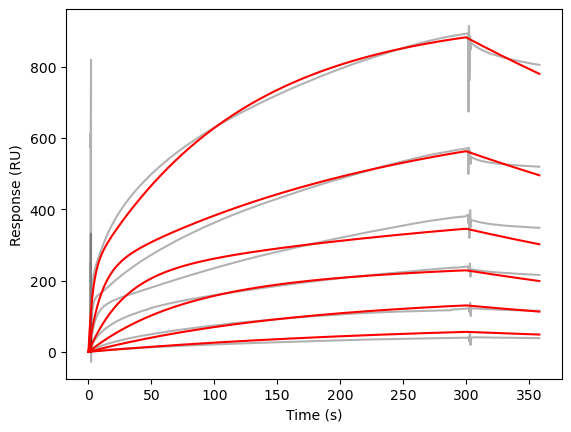

In [8]:
plt.plot(time/60, response_data[:6].T, label='Data',alpha = 0.3,c = "black")
plt.plot(time/60, result.best_fit.reshape(response_data.shape)[:6].T, '-', label='Fit',c = "red")
plt.xlabel("Time (s)")
plt.ylabel("Response (RU)")

In [9]:
#Maximum responses used for Scatchard and Hill-Langmuir model fitting
yy1 = channel_1[1::2,1000:].max(-1)
yy2 = channel_2[1::2,1000:].max(-1)


#Slight difference in maximum response achievable for each channel
#Therefore, maximum responses at each concentration were normalized to theoretical maximum response on that channel
theoretical_maximum1 = (result.params['Bmax1_1'] + result.params['Bmax1_2'])
theoretical_maximum2 = (result.params['Bmax2_1'] + result.params['Bmax2_2'])
yy1 = yy1/theoretical_maximum1
yy2 = yy2/theoretical_maximum2

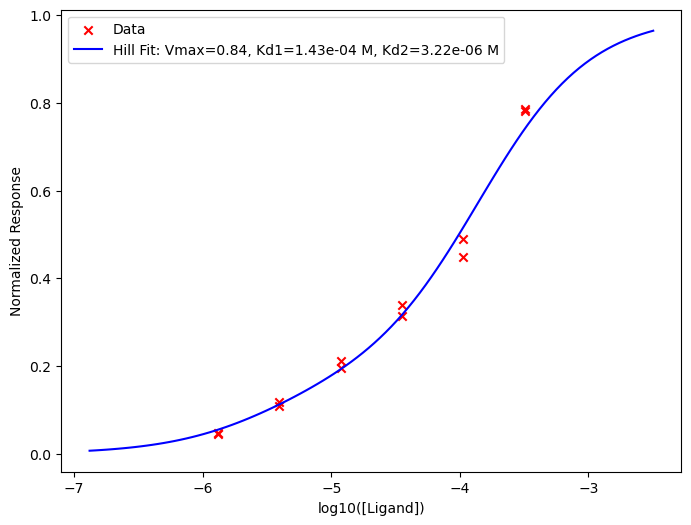

Values
ratio 0.8360270797833445
Kd1 0.00014283868999910573
Kd2 3.2224822306723915e-06
Error
ratio 0.06098812002695511
Kd1 2.498105698252611e-05
Kd2 2.8566498252540507e-06


In [10]:
# Hill-Langmuir model
def hill_equation(x, ratio, Kd1,Kd2):
    #ratio - ratio of maximum response achievable by binding at site 1
    #(1-ratio) - ratio of maximum response achievable by binding at site 2
    #Kd1 - Equilibrium binding affinity for binding to site 1
    #Kd2 - Equilibrium binding affinity for binding to site 2
    return (ratio* (10**x)/(Kd1 + (10**x))) + ((1-ratio) * (10**x)/(Kd2 + (10**x))) 

# Initial guesses for ratio, Kd1, and Kd2
initial_guesses = [0.5, 1e-5,1e-6]

#Fitting to both responses simultaneously...
xdata = np.log10(np.concatenate([xx,xx]))
ydata = np.concatenate([yy1,yy2])

# Perform the curve fit
params, covariance = curve_fit(hill_equation, xdata, ydata, p0=initial_guesses,
                              bounds=((0, 0,0), (1, np.inf, np.inf))
                              )

# Extract parameters
ratio, Kd1,Kd2 = params

# Generate fitted curve
x_fit = np.linspace(min(xdata)-1, max(xdata)+1, 100)
y_fit = hill_equation(x_fit, ratio, Kd1,Kd2)

# Plot the data and the fit
plt.figure(figsize=(8, 6))
plt.scatter(xdata, ydata, color='red', label='Data',marker = 'x')
plt.plot(x_fit, y_fit, label=f'Hill Fit: Vmax={ratio:.2f}, Kd1={Kd1:.2e} M, Kd2={Kd2:.2e} M',  color='blue')
plt.xlabel('log10([Ligand])')
plt.ylabel('Normalized Response')
plt.legend()
plt.show()
err = np.sqrt(np.diag(covariance))

print("Values")
[print(a,b) for a,b in zip(["ratio","Kd1","Kd2"],params)];
print("Error")
[print(a,b) for a,b in zip(["ratio","Kd1","Kd2"],err)];

In [11]:
# Scatchard model
def Scatchard_model(x, Vmax,ratio, Kd1,Kd2):
    return ((Vmax*ratio * (10**x)/(Kd1 + (10**x))) +
            (Vmax*(1-ratio) * (10**x)/(Kd2 + (10**x))) )/(10**x)

# Initial guesses for Vmax, Kd, and n
initial_guesses = [1.2,0.5, 1e-5,1e-6]

#Fitting to both responses simultaneously...
xdata = np.log10(np.concatenate([xx,xx]))
ydata = np.concatenate([yy1/xx,yy2/xx])

# Perform the curve fit
params, covariance = curve_fit(Scatchard_model, xdata, ydata, p0=initial_guesses,
                              bounds=((0,0, 0,0), (np.inf,1.0, np.inf, np.inf))
                              )

# Extract parameters
Vmax,ratio, Kd1,Kd2 = params

# Generate fitted curve
x_fit = np.linspace(min(xdata)-1, max(xdata)+1, 100)
y_fit = Scatchard_model(x_fit, Vmax, ratio,Kd1,Kd2)

perr = np.sqrt(np.diag(covariance))

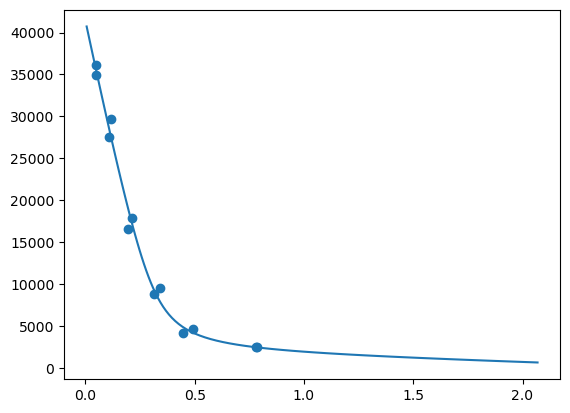

Values
Vmax 2.8086552165145586
ratio 0.8890622060906895
Kd1 0.0013451691119020805
Kd2 7.884250968468432e-06
Error
Vmax 9.148600444699584
ratio 0.34990525124679184
Kd1 0.005725332721473372
Kd2 1.0540587415286563e-06


In [12]:
plt.plot(y_fit*10**x_fit,y_fit)
plt.scatter(ydata*10**xdata,ydata)
plt.show()
print("Values")
[print(a,b) for a,b in zip(["Vmax","ratio","Kd1","Kd2"],params)];
print("Error")
[print(a,b) for a,b in zip(["Vmax","ratio","Kd1","Kd2"],perr)];